<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Biomate_NN_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tqdm
from time import time

# Estructura de los datos.

Consideramos un caso general, una base con datos de frecuencias de especies, cada observación de dimensión $k$, y supongamos que tenemos $n$ observaciones.

El output busca ser la clasificación en una de $d$ categorías, definidas ya sea por ciudad o localización-clima (pero de un sólo tipo).


# Datos de ejemplo

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Dataset_w_tags.csv")
df.head()
from sklearn.utils import shuffle
df = shuffle(df)###El ajuste depende de este shuffle*****

In [61]:
print(df.shape)

(237, 513)


Se tienen 237 observaciones, cada una es una muestra en una "localización".
Por renglón, se tienen frecuencias de "bichos" de 510 "dominant taxa".

En este caso, $k=510$, $n=237$.

In [62]:
ytags=df['Tag']
print(ytags)

219    Temperate forests_0
144       Dry grasslands_3
148               Boreal_5
233         Cold forests_3
97           Dry forests_0
              ...         
55          Cold forests_6
89           Dry forests_0
80           Dry forests_0
61          Cold forests_6
222    Temperate forests_0
Name: Tag, Length: 237, dtype: object


In [63]:
ytags

219    Temperate forests_0
144       Dry grasslands_3
148               Boreal_5
233         Cold forests_3
97           Dry forests_0
              ...         
55          Cold forests_6
89           Dry forests_0
80           Dry forests_0
61          Cold forests_6
222    Temperate forests_0
Name: Tag, Length: 237, dtype: object

In [64]:
import numpy as np
_,idx = np.unique(ytags,return_inverse=True)

Dados los datos con su respectiva clasificación. (En el ejemplo $d=12$)

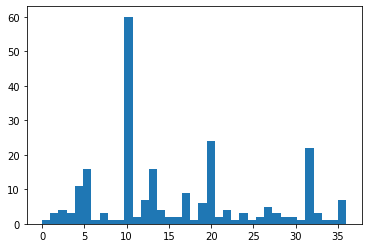

In [65]:
plt.hist(idx,bins=37)
plt.show()#Mala representatividad de clases.

# Definición del modelo.

# Partición de datos

In [66]:
from keras.utils import to_categorical
X_total=df.drop(columns=['Tag','Dominant_taxa_ID/ID_Environmental'])
Y_total=to_categorical(idx)

In [67]:
X_train=X_total[0:200]
Y_train=Y_total[0:200]

In [68]:
df.head()
k,n=X_train.shape
n=n#-indice, -tag
print(k,n)

200 511


In [69]:
input_shape = (n,)#=n
output_shape=len(np.unique(ytags))

In [70]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models


# Capas, neuronas, funciones de activación, loss.

In [72]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(n,), name='Input_Layer'))#Obligatoria
model.add(layers.Dense(10, activation='relu'))# Numero de capas ocultas: Opcional
model.add(layers.Dense(10, activation='relu'))# Numero de neuronas en cada capa: Opcional
model.add(layers.Dense(37, activation='Softmax', name='Output_Layer'))#Obligatoria
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import time
tic = time.time()

model.fit(x = X_train, 
           y = Y_train, 
          validation_data=[X_total[200:], Y_total[200:]],
          batch_size=50,
           epochs=200,
           verbose=2,shuffle=True)

print('seconds=', time.time()-tic)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                5120      
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 Output_Layer (Dense)        (None, 37)                407       
                                                                 
Total params: 5,637
Trainable params: 5,637
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4/4 - 1s - loss: 10.6835 - accuracy: 0.0200 - val_loss: 7.5658 - val_accuracy: 0.0270 - 1s/epoch - 267ms/step
Epoch 2/200
4/4 - 0s - loss: 6.3449 - accuracy: 0.0300 - val_loss: 5.7665 - val_accuracy: 0.0000e+00 - 142ms/epoch - 36ms/step
Epoch 3/200
4/4 - 0s - loss: 4.7748 - accuracy: 0.0200 - val_loss: 

In [13]:
model.save('primer_intento.h5')

In [17]:
import numpy as np

test_predicted_labels = model.predict(X_total[200:])
test_true_labels      = np.argmax(Y_total[200:],axis=1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

2/2 [==============================] - 0s 7ms/step


# Segundo intento. Leave One Out Cross Validation Method.

Sean $X_1,X_2,\ldots, X_n$ las observaciones. 
Para cada $i\in\{1,2,\ldots,n\}$ se define una red $RN(i)$, que es entrenada con los datos 
$$X_{train}^{(i)}=\{X\}_{i=1}^n - \{X_i\}$$
$$X_{val}^{(i)}=\{X_i\}$$


Sea $Y_{pred}^{(i)}=RN(i)(X_i)$ la predicción del dato de entrenamiento.

Para cada $i$, se obtiene un error $\epsilon_i\in\{0,1\}$.

Definimos una precisión global como 
$$\frac{1}{n}\sum_{i=1}^n \epsilon_i$$

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

df = pd.read_csv("Dataset_w_tags.csv")
df.head()
y_tags=df['Tag']
df_X=df.drop(columns=['Tag','Dominant_taxa_ID/ID_Environmental'])
_,idx_Total = np.unique(ytags,return_inverse=True)
#from sklearn.utils import shuffle
#df = shuffle(df)###El ajuste depende de este shuffle*****

In [ ]:
batch_size_fijo=10
epochs_fijas=200
def RN(i):#Recibe $i\in\{0,\ldots,n\}$
    X_total=df_X
    Y_total=idx_Total
    X_train_i=X_total.drop(index=i)
    Y_train_i=np.delete(idx_Total,i)
    X_val=df_X[i]
    Y_val=idx_Total[i]###Que sea de tipo categorical_keras
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(n,), name='Input_Layer'))#Obligatoria
    model.add(layers.Dense(64, activation='relu'))# Numero de capas ocultas: Opcional
    model.add(layers.Dense(32, activation='relu'))# Numero de neuronas en cada capa: Opcional
    model.add(layers.Dense(37, activation='Softmax', name='Output_Layer'))#Obligatoria
    model.summary()
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
    model.fit(x = X_train, 
            y = Y_train, 
            validation_data=[X_total[200:], Y_total[200:]],
            batch_size=batch_size_fijo,
            epochs=epochs_fijas,
            verbose=2,shuffle=True,callbacks=[callback])
    #Asumimos que se terminó de entrenar
    test_predicted_labels = model.predict(X_val)
    test_true_labels      = np.argmax(Y_val,axis=1)
    test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

In [41]:
A

,Dominant_taxa_ID/ID_Environmental,OTU_10,OTU_24,OTU_17316,OTU_124,OTU_196,OTU_111,OTU_16,OTU_20,OTU_198,...,OTU_7807,OTU_20167,OTU_3763,OTU_998,OTU_618,OTU_961,OTU_3160,OTU_37856,OTU_882,Tag
1,2,94,324,51,0,26,1,1,4,9,...,0,0,0,0,0,0,0,0,0,Boreal_9
2,3,92,82,22,3,78,1,1,0,0,...,0,0,0,0,2,0,0,0,0,Cold forests_1
3,4,58,79,23,27,49,11,63,14,94,...,0,1,1,0,6,2,0,2,1,Temperate forests_1
4,5,306,214,12,15,50,24,13,6,48,...,1,0,3,0,3,0,0,1,0,Grasslands_6
5,6,288,502,12,6,48,12,1,14,7,...,0,0,0,0,0,0,0,0,0,Grasslands_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,233,20,18,21,32,16,9,65,66,2,...,0,3,2,1,1,2,5,0,1,Dry forests_0
233,234,788,214,31,90,194,40,10,1,15,...,0,0,0,0,9,0,0,0,0,Cold forests_3
234,235,791,156,5,88,62,89,31,3,13,...,0,0,0,1,7,0,0,0,0,Cold forests_3
235,236,599,149,14,20,43,61,22,3,24,...,0,0,0,0,8,0,0,0,0,Cold forests_3
